# Sistem Pemberi Rekomendasi Produk E-Commerce Menggunakan PCA dan K-Means Clustering

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
import matplotlib.cm as cm
pd.options.mode.chained_assignment = None  # default='warn'

## Preprocessing

### Load dataset sport

In [2]:
dfp = pd.read_csv('data/olist_sport_rating_dataset.csv')
dfp.shape

(15944, 3)

In [3]:
dfp.head()

,customer_unique_id,product_id,rating
0,68a5590b9926689be4e10f4ae2db21a8,fd25ab760bfbba13c198fa3b4f1a0cd3,4
1,d16000272660a1fef81482ad75ba572a,3880d25d502b15b1de6fddc42ad1d67a,5
2,f51a647a551b866c440921b7f2b5683f,a76bb75d78ce6aa4a5202051b4f88a83,4
3,bd4174fe2e76f6818b913f6dac96b49a,ee92961b88199a0d4329a6beca8f63da,3
4,e72ed956534642d2d41d7b90dd18f378,adb1f1939b613f3078806b6afcca0e51,5


In [4]:
df = pd.read_csv('data/olist_sport_user_dataset.csv')

In [5]:
df.head()

,customer_unique_id,payment_type,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential
0,00053a61a98854899e70ed204dd4bafe,credit_card,3.0,419.18,-25.4313,-49.2792,1.0
1,0005ef4cd20d2893f0d9fbd94d3c0d97,credit_card,4.0,129.76,-2.5453,-44.2350,1.0
2,00115fc7123b5310cf6d3a3aa932699e,credit_card,1.0,76.11,-15.8232,-47.9871,1.0
3,0019e8c501c85848ac0966d45226fa1d,credit_card,2.0,197.27,-15.6087,-56.0863,1.0
4,003c2067070f5b3d923235b1ea1cc17b,boleto,1.0,147.38,-6.5833,-40.1389,1.0


In [6]:
df.describe(include='all')

,customer_unique_id,payment_type,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential
count,7422,7422,7422.000000,7422.000000,7422.000000,7422.000000,7422.000000
unique,7414,4,NaN,NaN,NaN,NaN,NaN
top,8e2c92b2442298bd653b0e9aadf4c313,credit_card,NaN,NaN,NaN,NaN,NaN
freq,2,5668,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2.477953,148.886874,-21.282984,-46.327820,1.021692
std,NaN,NaN,2.388320,187.418710,5.524935,4.037406,0.501380
min,NaN,NaN,1.000000,0.050000,-33.689900,-69.261400,1.000000
25%,NaN,NaN,1.000000,65.000000,-23.602700,-48.404400,1.000000
50%,NaN,NaN,1.000000,108.880000,-22.943400,-46.654200,1.000000
75%,NaN,NaN,3.000000,167.185000,-20.188100,-43.920650,1.000000


### Define input data

In [7]:
selected_n_comp = int(input("Number of PCA component (recommended = 2):"))
selected_n_clus = int(input("Number of cluster (recommended = 4):"))
selected_n_neighbors = int(input("Number of Collaborative Filtering Neighbors (recommended = 30):"))

Number of PCA component (recommended = 2):2
Number of cluster (recommended = 4):4
Number of Collaborative Filtering Neighbors (recommended = 30):30


### Missing data treatment

In [8]:
df.describe()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential
count,7422.000000,7422.000000,7422.000000,7422.000000,7422.000000
mean,2.477953,148.886874,-21.282984,-46.327820,1.021692
std,2.388320,187.418710,5.524935,4.037406,0.501380
min,1.000000,0.050000,-33.689900,-69.261400,1.000000
25%,1.000000,65.000000,-23.602700,-48.404400,1.000000
50%,1.000000,108.880000,-22.943400,-46.654200,1.000000
75%,3.000000,167.185000,-20.188100,-43.920650,1.000000
max,24.000000,4163.510000,3.362100,-34.827400,28.000000


In [9]:
# isi null value pada kolom total_payment_sequential dengan nilai median
df['total_payment_sequential'].fillna(df['total_payment_sequential'].median(), inplace=True)

# isi null value pada kolom total_payment_sequential dengan nilai rata-rata
df['total_payment_installments'].fillna(df['total_payment_installments'].mean(), inplace=True)

# isi null value pada kolom total_payment_value dengan nilai median
df['total_payment_value'].fillna(df['total_payment_value'].median(), inplace=True)

# isi null value pada kolom payment_type dengan nilai median
df['payment_type'].fillna(df['payment_type'].mode().iloc[0], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7422 entries, 0 to 7421
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_unique_id          7422 non-null   object 
 1   payment_type                7422 non-null   object 
 2   total_payment_installments  7422 non-null   float64
 3   total_payment_value         7422 non-null   float64
 4   geolocation_lat             7422 non-null   float64
 5   geolocation_lng             7422 non-null   float64
 6   total_payment_sequential    7422 non-null   float64
dtypes: float64(5), object(2)
memory usage: 406.0+ KB


### Outlier treatment

E:\Program Files\Anaconda3\envs\base2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Program Files\Anaconda3\envs\base2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Program Files\Anaconda3\envs\base2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

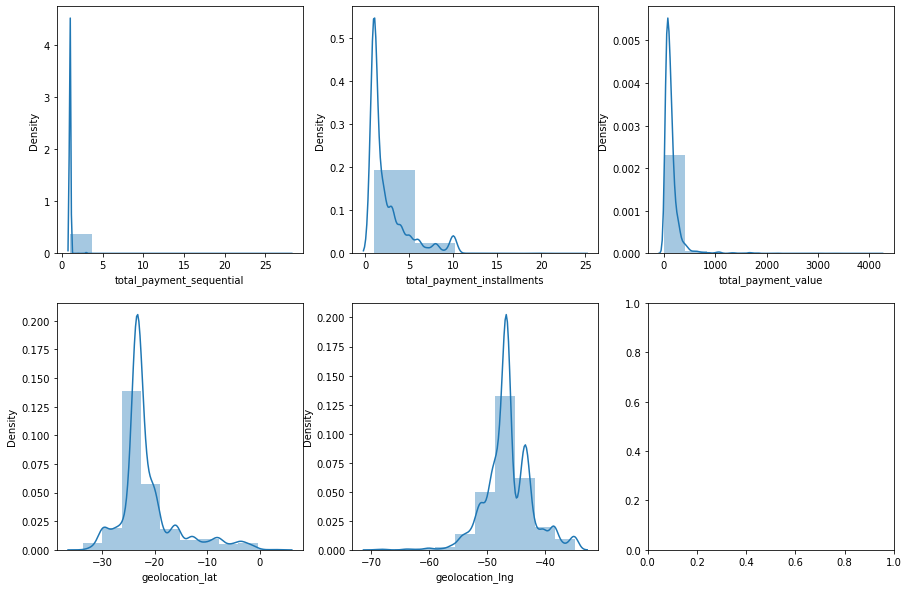

In [11]:
f, ax = plt.subplots(2, 3, figsize=(15,10))
vis1 = sns.distplot(df["total_payment_sequential"], bins=10, ax=ax[0][0])
vis2 = sns.distplot(df["total_payment_installments"],bins=5, ax= ax[0][1])
vis3 = sns.distplot(df["total_payment_value"],bins=10, ax=ax[0][2])
vis4 = sns.distplot(df["geolocation_lat"],bins=10, ax=ax[1][0])
vis5 = sns.distplot(df["geolocation_lng"],bins=10, ax=ax[1][1])

#### Eliminasi outlier dengan Interquartil Range (IQR)

In [12]:
df.shape

(7422, 7)

In [13]:
# menghitung jumlah row yg dianggap outlier
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
IQR = q3 - q1
print(IQR)

mask = (df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))
dfout = df.copy()
dfout[mask] = np.nan

total_payment_installments      2.00000
total_payment_value           102.18500
geolocation_lat                 3.41460
geolocation_lng                 4.48375
total_payment_sequential        0.00000
dtype: float64


C:\Users\Dendy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  import sys


In [14]:
dfout.isna().sum()

customer_unique_id               0
payment_type                     0
total_payment_installments     596
total_payment_value            467
geolocation_lat               1173
geolocation_lng                308
total_payment_sequential        42
dtype: int64

In [15]:
cleandf = df[~((df < (q1 - 1.5 * IQR)) |(df > (q3 + 1.5 * IQR))).any(axis=1)]
# cleandf.shape

C:\Users\Dendy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  """Entry point for launching an IPython kernel.


In [16]:
cleandf.describe()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential
count,5476.000000,5476.000000,5476.000000,5476.000000,5476.0
mean,1.807408,109.390414,-22.541442,-46.565584,1.0
std,1.280788,65.830227,2.422928,2.735688,0.0
min,1.000000,0.050000,-28.717400,-54.963200,1.0
25%,1.000000,58.280000,-23.597800,-47.890200,1.0
50%,1.000000,93.020000,-23.048300,-46.659250,1.0
75%,2.000000,144.025000,-21.672950,-44.249675,1.0
max,6.000000,320.230000,-15.152600,-39.041600,1.0


### Encoding data
Convert categorical data into numerical data

In [17]:
# encode kolom verify dengan nilai True = 1 dan False = 0
df_enc = pd.get_dummies(cleandf, columns=["payment_type"])
# df_enc.head()

In [18]:
df_enc.describe(include='all')

,customer_unique_id,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
count,5476,5476.000000,5476.000000,5476.000000,5476.000000,5476.0,5476.000000,5476.000000,5476.000000,5476.000000
unique,5470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,182053495bc94c2f41090ce8c41be266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.807408,109.390414,-22.541442,-46.565584,1.0,0.225164,0.745982,0.016253,0.012600
std,NaN,1.280788,65.830227,2.422928,2.735688,0.0,0.417729,0.435347,0.126458,0.111552
min,NaN,1.000000,0.050000,-28.717400,-54.963200,1.0,0.000000,0.000000,0.000000,0.000000
25%,NaN,1.000000,58.280000,-23.597800,-47.890200,1.0,0.000000,0.000000,0.000000,0.000000
50%,NaN,1.000000,93.020000,-23.048300,-46.659250,1.0,0.000000,1.000000,0.000000,0.000000
75%,NaN,2.000000,144.025000,-21.672950,-44.249675,1.0,0.000000,1.000000,0.000000,0.000000


### Aggregate data

In [19]:
# menyederhanakan df_sample_tmp
df_sample = pd.DataFrame()
df_sample['total_payment_installments'] = df_enc.groupby(['customer_unique_id'])['total_payment_installments'].mean()
df_sample['total_payment_value'] = df_enc.groupby(['customer_unique_id'])['total_payment_value'].mean()
df_sample['geolocation_lat'] = df_enc.groupby(['customer_unique_id'])['geolocation_lat'].mean()
df_sample['geolocation_lng'] = df_enc.groupby(['customer_unique_id'])['geolocation_lng'].mean()
df_sample['total_payment_sequential'] = df_enc.groupby(['customer_unique_id'])['total_payment_sequential'].mean()
df_sample['payment_type_boleto'] = df_enc.groupby(['customer_unique_id'])['payment_type_boleto'].sum()
df_sample['payment_type_credit_card'] = df_enc.groupby(['customer_unique_id'])['payment_type_credit_card'].sum()
df_sample['payment_type_debit_card'] = df_enc.groupby(['customer_unique_id'])['payment_type_debit_card'].sum()
df_sample['payment_type_voucher'] = df_enc.groupby(['customer_unique_id'])['payment_type_voucher'].sum()
df_sample.reset_index(drop=False, inplace=True)
df_sample.shape

(5470, 10)

In [20]:
# menentukan X dan y dataset
X = df_sample.copy()
X.drop(['customer_unique_id'], inplace=True, axis=1)

# y untuk statified splitting data
y = df_sample.loc[:, ["customer_unique_id"]]


In [21]:
X.head()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,1.0,76.11,-15.8232,-47.9871,1.0,0,1,0,0
1,1.0,103.47,-22.2848,-42.5317,1.0,1,0,0,0
2,1.0,158.74,-23.6295,-46.5241,1.0,1,0,0,0
3,1.0,94.35,-23.5364,-46.7960,1.0,1,0,0,0
4,1.0,123.39,-19.8629,-43.8607,1.0,1,0,0,0


### K-Fold Cross Validation

In [22]:
kf = KFold(n_splits=5, random_state=3, shuffle=True)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [24]:
print(X_train.shape)
print(X_test.shape)

(4376, 9)
(1094, 9)


#### Standardize data

In [25]:
sc = StandardScaler()
X_train[['total_payment_installments', 'total_payment_value','geolocation_lat', 'geolocation_lng']] = sc.fit_transform(X_train[['total_payment_installments', 'total_payment_value','geolocation_lat', 'geolocation_lng']])
X_test[['total_payment_installments', 'total_payment_value','geolocation_lat', 'geolocation_lng']] = sc.fit_transform(X_test[['total_payment_installments', 'total_payment_value','geolocation_lat', 'geolocation_lng']])

# X_train[X_train.iloc[:, 1:]] = sc.fit_transform(X_train.iloc[:, 1:])
# X_test[X_test.iloc[:, 1:]] = sc.fit_transform(X_test.iloc[:, 1:])


In [26]:
X_train.head()

,total_payment_installments,total_payment_value,geolocation_lat,geolocation_lng,total_payment_sequential,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,-0.634538,-1.166150,-0.449417,-0.005827,1.0,0,1,0,0
1,1.729071,3.140194,0.901737,2.245756,1.0,0,1,0,0
2,-0.634538,-0.641016,-0.440324,-0.014906,1.0,0,0,1,0
3,-0.634538,0.142483,-0.393583,0.032726,1.0,0,1,0,0
4,0.153331,0.593210,1.074710,0.961564,1.0,0,1,0,0


#### Create K-Fold

In [27]:
X_train_cv = []
X_val_cv = []
y_train_cv = []
y_val_cv = []

i = 0
for train_index, val_index in kf.split(X_train):
    X_train_cv.append(X_train.iloc[train_index,:])
    X_val_cv.append(X_train.iloc[val_index,:])
    y_train_cv.append(y_train.iloc[train_index,:])
    y_val_cv.append(y_train.iloc[val_index,:])
    
    
    X_train_cv[i].reset_index(drop=True, inplace=True)
    y_train_cv[i].reset_index(drop=True, inplace=True)
    X_val_cv[i].reset_index(drop=True, inplace=True)
    y_val_cv[i].reset_index(drop=True, inplace=True)
    
    i += 1

### Apply PCA

In [28]:
X_train_cv_pca = []
X_val_cv_pca = []

pca_new = PCA(n_components=selected_n_comp)

for i in range(len(X_train_cv)):    
    X_train_cv_pca.append(pd.DataFrame(pca_new.fit_transform(X_train_cv[i].iloc[:, :4])))
    X_val_cv_pca.append(pd.DataFrame(pca_new.transform(X_val_cv[i].iloc[:, :4])))

# save pca into pickle file
# model_filename = "pca_model.pkl"
# pickle.dump(pca_new, open(model_filename,'wb'))

# apply PCA to X_train data
X_train_pca = pd.DataFrame(pca_new.transform(X_train.iloc[:, :4]))
X_train_pca = X_train_pca.assign(payment_type_credit_card = X_train.loc[:, 'payment_type_credit_card'])
X_train_pca = X_train_pca.assign(payment_type_debit_card = X_train.loc[:, 'payment_type_debit_card'])
X_train_pca = X_train_pca.assign(payment_type_voucher = X_train.loc[:, 'payment_type_voucher'])
X_train_pca = X_train_pca.assign(payment_type_boleto = X_train.loc[:, 'payment_type_boleto'])

In [29]:
for i in range(len(X_train_cv)):
    X_train_cv_pca[i] = X_train_cv_pca[i].assign(payment_type_credit_card = X_train_cv[i].loc[:, 'payment_type_credit_card'])
    X_train_cv_pca[i] = X_train_cv_pca[i].assign(payment_type_debit_card = X_train_cv[i].loc[:, 'payment_type_debit_card'])
    X_train_cv_pca[i] = X_train_cv_pca[i].assign(payment_type_voucher = X_train_cv[i].loc[:, 'payment_type_voucher'])
    X_train_cv_pca[i] = X_train_cv_pca[i].assign(payment_type_boleto = X_train_cv[i].loc[:, 'payment_type_boleto'])
       
    X_val_cv_pca[i] = X_val_cv_pca[i].assign(payment_type_credit_card = X_val_cv[i].loc[:, 'payment_type_credit_card'])
    X_val_cv_pca[i] = X_val_cv_pca[i].assign(payment_type_debit_card = X_val_cv[i].loc[:, 'payment_type_debit_card'])
    X_val_cv_pca[i] = X_val_cv_pca[i].assign(payment_type_voucher = X_val_cv[i].loc[:, 'payment_type_voucher'])
    X_val_cv_pca[i] = X_val_cv_pca[i].assign(payment_type_boleto = X_val_cv[i].loc[:, 'payment_type_boleto'])


In [30]:
X_val_cv_pca[0].head()

,0,1,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_boleto
0,-1.136136,-0.660574,1,0,0,0
1,-0.402720,0.069010,1,0,0,0
2,-0.362986,0.124730,1,0,0,0
3,2.040734,-0.227763,1,0,0,0
4,-0.147724,1.263423,1,0,0,0


### Scale data using min max scaler

In [31]:
for i in range(len(X_train_cv_pca)):
    scaler = MinMaxScaler()
    X_train_cv_pca[i].loc[:, X_train_cv_pca[i].columns] = scaler.fit_transform(X_train_cv_pca[i].loc[:, X_train_cv_pca[i].columns])
    X_val_cv_pca[i].loc[:, X_val_cv_pca[i].columns] = scaler.transform(X_val_cv_pca[i].loc[:, X_val_cv_pca[i].columns])
    
# implement scaling for X_train
X_train_pca.loc[:, X_train_pca.columns] = scaler.transform(X_train_pca.loc[:, X_train_pca.columns])

# save scaler with pickle
# model_filename = "scaler_model.pkl"
# pickle.dump(scaler, open(model_filename,'wb'))

E:\Program Files\Anaconda3\envs\base2\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
E:\Program Files\Anaconda3\envs\base2\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
E:\Program Files\Anaconda3\envs\base2\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
E:\Program Files\Anaconda3\envs\base2\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised i

In [32]:
X_train_pca.head()

,0,1,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,payment_type_boleto
0,0.317853,0.293700,1.0,0.0,0.0,0.0
1,0.836091,0.631843,1.0,0.0,0.0,0.0
2,0.338639,0.335435,0.0,1.0,0.0,0.0
3,0.375958,0.392996,1.0,0.0,0.0,0.0
4,0.589705,0.373011,1.0,0.0,0.0,0.0


## Model
K-Means with Silhouette Coefficient

### PCA K-Means

#### Apply PCA K-Means to Train and Validation Dataset

In [33]:
val_sil_val = {1:None, 2:None, 3:None, 4:None, 5:None}

In [34]:
X_val_cv_pca[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   0                         876 non-null    float64
 1   1                         876 non-null    float64
 2   payment_type_credit_card  876 non-null    float64
 3   payment_type_debit_card   876 non-null    float64
 4   payment_type_voucher      876 non-null    float64
 5   payment_type_boleto       876 non-null    float64
dtypes: float64(6)
memory usage: 41.2 KB


In [35]:
for idx in range(len(X_val_cv_pca)):
    # KMeans clustering
    km_val = KMeans(n_clusters=selected_n_clus, random_state=30)
    km_val.fit(X_train_cv_pca[idx])
    y_val_predict = km_val.predict(X_val_cv_pca[idx])
    y_train_predict = km_val.predict(X_train_pca)

    # Silhouette score
    silhouette_val = silhouette_score(X_val_cv_pca[idx], y_val_predict)
    val_sil_val[idx+1] = silhouette_val
    
    # tambah kolom kluster dataset val
    y_val_cv[idx].loc[:, 'cluster'] = pd.Series(y_val_predict)    
    
    # tambah kolom kluster dataset train
    y_train.loc[:, 'cluster'] = pd.Series(y_train_predict)

E:\Program Files\Anaconda3\envs\base2\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
E:\Program Files\Anaconda3\envs\base2\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
E:\Program Files\Anaconda3\envs\base2\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
E:\Program Files\Anaconda3\envs\base2\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised i

In [36]:
# Average silhoette coef
for key, values in val_sil_val.items():
    print("fold:",key,"silhouette coef:", values)

fold: 1 silhouette coef: 0.8344719603726564
fold: 2 silhouette coef: 0.829919956107309
fold: 3 silhouette coef: 0.8366961788135795
fold: 4 silhouette coef: 0.8343261388324562
fold: 5 silhouette coef: 0.8391905988879902


#### Number of data for each cluster

In [37]:
y_val_cv[0].loc[:, 'cluster'].value_counts()

0    664
1    185
2     16
3     11
Name: cluster, dtype: int64

## Collaborative Filtering

### Rating prediction  function based on user similarity

In [38]:
# prediction rating function based on num of neighbors
def predict_rating(activeUser, itemPredicted, rating_matrix, user_sim, selection_mode = 'neighbors', n=1):
    pembilang = []
    res = None
    penyebut = 0.0001 # to avoid division by zero, penyebut assign with 0.0001
    sim_avg = [] # similarity average
    
    # check selection mode
    if selection_mode == 'neighbors':
        i = 0
        while (i < n) and (i < len(user_sim)):           
            # rbp: rating user b for product p (predicted product)
            rbp = rating_matrix.loc[user_sim.keys()[i], itemPredicted]

            # avg_rb: average rating user b
            avg_rb = rating_matrix.loc[user_sim.keys()[i]].mean()

            # check if similarity is None
            if not math.isnan(user_sim.values[i]):
                pembilang.append(user_sim.values[i] * (rbp - avg_rb))
                penyebut += user_sim.values[i]
                sim_avg.append(user_sim.values[i])
                i += 1
                
            else:
                i += 1
    elif selection_mode == 'treshold':
            for i in range(len(user_sim)):
                # treshold user selection
                if user_sim.values[i] >= n:            
                    # rbp: rating user b for product p (predicted product)
                    rbp = rating_matrix.loc[user_sim.keys()[i], itemPredicted]

                    # avg_rb: average rating user b
                    avg_rb = rating_matrix.loc[user_sim.keys()[i]].mean()
                    pembilang.append(user_sim.values[i] * (rbp - avg_rb))
                    penyebut += user_sim.values[i]
                    sim_avg.append(user_sim.values[i])
                    
    res = rating_matrix.loc[activeUser].mean() + (sum(pembilang) / penyebut)
    avg_sim = (sum(sim_avg)/len(sim_avg))
    return res, avg_sim
    

### Predict user rating  function based on user similarity

In [39]:
def predict_user_rating(cust_id, rating_matrix, selection_mode, n):    
    
    # get rated product from active user
    prod = dict(rating_matrix.loc[cust_id].notnull())
    ratedProdList = [key for key, val in prod.items() if val == True]

    # get un-rated product        
    predictProdList = [key for key, val in prod.items() if val == False]

    # dict for save predict data
    predicted_prod = {'predicted_prod_id': [], 'predicted_rating': []}
    
    avg_sim_users = []

    for predictItem in predictProdList:
        # get user who have rated predicted item 
        user1 = list(rating_matrix[rating_matrix[predictItem].notnull()].index)

        # skip loop if no user rated predicted item
        if len(user1) <= 0:
            continue

        # get user who rated predicted item
        dftmp = rating_matrix.loc[user1]

        # get user who rated predicted item and rated same item with active user
        user2 = []
        for product in ratedProdList:
            a = list(dftmp[dftmp[product].notnull()].index)
            if a not in user2:
                for userA in a:
                    user2.append(userA)

        dftmp2 = rating_matrix.loc[[cust_id] + user2]  

        # improve sparsity problem by fill null with average value from all neighbors
        userAvgTmp = dftmp2.mean(axis=1)
        neighbors_avg = userAvgTmp.mean()
        dftmp2.fillna(neighbors_avg, inplace=True)
        
        # calc similarity with pearson correlation    
        # user_sim = dftmp2.T.corr().iloc[1:, 0] 
        
        # calc similarity with cosine similarity    
        sim_tmp = 1-pairwise_distances(dftmp2, metric='cosine')
        user_sim = pd.Series(sim_tmp[0][1:], index=dftmp2.index[1:])
        
        # remove active user from user_sim
        if cust_id in user_sim.index:            
            user_sim.drop(cust_id, inplace=True)
        # user_sim.sort_values(ascending=False, inplace=True)        
        
        # check if user_sim is empty
        if len(user_sim) != 0:
            # predict rating
            rating, avg_sim = predict_rating(cust_id, predictItem, rating_matrix, user_sim, selection_mode, n)
            predicted_prod['predicted_rating'].append(rating)
            predicted_prod['predicted_prod_id'].append(predictItem)
            avg_sim_users.append(avg_sim)
    avg_sim_val = sum(avg_sim_users)/len(avg_sim_users)
    return predicted_prod, avg_sim_val

### Recommender system function

In [40]:
def recommender_system(cust_id, userIdData, userData, userClusterDf, ratingDf, nRec):
    # get activeUserData in userData by cust_id
    idx = userIdData[userIdData.customer_unique_id == cust_id].index
    activeUserData = userData.iloc[idx]
    
    # reduce dimensionality with PCA
    activeUserData_pca = pca_new.transform(activeUserData.iloc[:, :4])
    activeUserData_pca = pd.DataFrame(activeUserData_pca)
    activeUserData_pca = activeUserData_pca.assign(payment_type_credit_card = activeUserData['payment_type_credit_card'].iloc[0])
    activeUserData_pca = activeUserData_pca.assign(payment_type_debit_card = activeUserData['payment_type_debit_card'].iloc[0])
    activeUserData_pca = activeUserData_pca.assign(payment_type_voucher = activeUserData['payment_type_voucher'].iloc[0])
    activeUserData_pca = activeUserData_pca.assign(payment_type_boleto = activeUserData['payment_type_boleto'].iloc[0])
    
    # Scaling data with MinMaxScaler
    activeUserData_pca[activeUserData_pca.columns] = scaler.transform(activeUserData_pca)    
    
    # predict cluster with K-Means
    predicted_cluster = km_val.predict(activeUserData_pca)
    
    # get user in predicted cluster
    dftmp = userClusterDf[userClusterDf['cluster'] == predicted_cluster[0]]   
    
    # assign active user into dftmp
    dftmp = dftmp.append({'customer_unique_id': cust_id, 'cluster': predicted_cluster[0]}, ignore_index=True)
    
    # join with df rating
    df_rating = pd.merge(dftmp, ratingDf[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])
    
    # drop user who only rated below 2 product
    user_freq = dict(df_rating['customer_unique_id'].value_counts())
    user_list = [key for key, val in user_freq.items() if (val < 2) and (not key == cust_id)]
    idx = df_rating[df_rating['customer_unique_id'].isin(user_list)].index
    df_rating.drop(idx, axis=0,inplace=True)
    
    # create rating matrix
    rating_matrix = df_rating.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')
    
    # predict rating
    res, avg_sim = predict_user_rating(cust_id, rating_matrix, 'neighbors', nRec)

    return avg_sim, get_recommendation(res, nRec)

### Recommender system evaluation function

In [41]:
# evaluation based on rating prediction with memory-based
def rs_user_evaluation(cust_id, userItemMatrix, selection_mode, n):
    # get product id from active user    
    prod = dict(userItemMatrix.loc[cust_id, :].notnull())
    ratedProdList = [key for key, val in prod.items() if val == True]
    
    # get actual rating from rated product
    prod = dict(userItemMatrix.loc[cust_id])
    actualRating = [val for key, val in prod.items() if key in ratedProdList]
    
    # list to store predicted rating
    predictedRating = []
    
    avg_sims = []
    
    for ratedItem in ratedProdList:
        # get user who have rated predicted item 
        user1 = list(userItemMatrix[userItemMatrix[ratedItem].notnull()].index)

        # skip loop if no user rated predicted item
        if len(user1) <= 0:
            continue

        # get user who rated predicted item
        dftmp = userItemMatrix.loc[user1]

        # get user who rated predicted item and rated same item with active user
        user2 = []
        for product in ratedProdList:
            a = list(dftmp[dftmp[product].notnull()].index)
            if a not in user2:
                for userA in a:
                    user2.append(userA)

        dftmp2 = userItemMatrix.loc[[cust_id] + user2]      
        # improve sparsity problem by fill null with average value from all neighbors
        userAvgTmp = dftmp2.mean(axis=1)
        neighbors_avg = userAvgTmp.mean()
        dftmp2.fillna(neighbors_avg, inplace=True)
        
        # calc similarity with pearson correlation    
        # user_sim = dftmp2.T.corr().iloc[1:, 0] 
        
        sim_tmp = 1-pairwise_distances(dftmp2, metric='cosine')
        user_sim = pd.Series(sim_tmp[0][1:], index=dftmp2.index[1:])

        # remove active user from user_sim
        if cust_id in user_sim.index:            
            user_sim.drop(cust_id, inplace=True)
        # user_sim.sort_values(ascending=False, inplace=True)        
        
        # check if user_sim is empty
        if len(user_sim) != 0:
            # predict rating
            rating, avg_sim = predict_rating(cust_id, ratedItem, userItemMatrix, user_sim, selection_mode, n)
            predictedRating.append(rating)
            avg_sims.append(avg_sim)
        else: # if empty then append None to predicted rating
            predictedRating.append(None)
            avg_sims.append(0)
    
    avg_sim_users = sum(avg_sims)/ len(avg_sims)
    
    # null value check
    if None in predictedRating:
        # remove null value from predictedRating and actual rating
        nullIdx = [i for i, val in enumerate(predictedRating) if not val]
        actualRatingClean = [val for i, val in enumerate(actualRating) if i not in nullIdx]
        predictedRatingClean = [val for i, val in enumerate(predictedRating) if i not in nullIdx]
    else:
        actualRatingClean = actualRating
        predictedRatingClean = predictedRating
    
    # rmse & mae calculation
    if (len(actualRatingClean) != 0) or (len(predictedRatingClean) != 0):
        rmse = mean_squared_error(actualRatingClean, predictedRatingClean, squared=False)
        mae = mean_absolute_error(actualRatingClean, predictedRatingClean)
        
        # dataframe result
        res_df = pd.DataFrame(ratedProdList, columns=['product_id'])
        res_df['predicted_rating'] = predictedRating
        res_df['actual_rating'] = actualRating
        # print(res_df['predicted_rating'].count(),' out of ',len(res_df),' items can be predicted:',(res_df['predicted_rating'].count()/len(res_df))*100,'%')
        n_item_percentage = (res_df['predicted_rating'].count()/len(res_df))*100
    else:
        rmse = None
        mae = None
        res_df = pd.DataFrame()
        n_item_percentage = 0
    return rmse, mae, res_df, n_item_percentage, avg_sim_users

### Generate n-recommendation function

In [42]:
def get_recommendation(result, n):
    if n != None:
        return pd.DataFrame(result).sort_values('predicted_rating', ascending=False).head(n)
    else:
        return pd.DataFrame(result).sort_values('predicted_rating', ascending=False)

## PCA-KM CF Method

### Evaluate PCA-KM CF all neighbors with test data

#### Apply PCA

In [43]:
X_test_pca = pd.DataFrame(pca_new.transform(X_test.iloc[:, :4]))

In [44]:
X_test_pca = X_test_pca.assign(payment_type_credit_card = X_test.loc[:, 'payment_type_credit_card'])
X_test_pca = X_test_pca.assign(payment_type_debit_card = X_test.loc[:, 'payment_type_debit_card'])
X_test_pca = X_test_pca.assign(payment_type_voucher = X_test.loc[:, 'payment_type_voucher'])
X_test_pca = X_test_pca.assign(payment_type_boleto = X_test.loc[:, 'payment_type_boleto'])

#### Scaling Test Dataset

In [45]:
X_test_pca[X_test_pca.columns] = scaler.transform(X_test_pca)

E:\Program Files\Anaconda3\envs\base2\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


#### Apply K-Means

E:\Program Files\Anaconda3\envs\base2\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Dataset test silhouette coef: 0.845154364000818


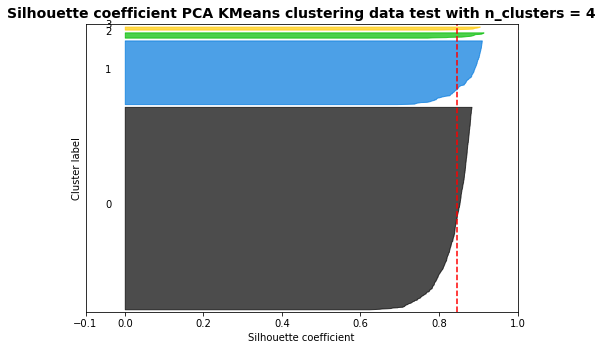

In [46]:
# KMeans clustering
y_test_predict = km_val.predict(X_test_pca)

# Silhouette score
silhouette_val = silhouette_score(X_test_pca, y_test_predict)
print('Dataset test silhouette coef:', silhouette_val)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_test_pca, y_test_predict)

# Create figure
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1])
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X_test_pca) + (selected_n_clus + 1) * 10])
y_lower = 10
for i in range(selected_n_clus):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y_test_predict == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / selected_n_clus)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_xlabel("Silhouette coefficient")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_val, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title(("Silhouette coefficient PCA KMeans clustering data test with n_clusters = %d" % selected_n_clus), fontsize=14, fontweight='bold')

plt.show()

# tambah kolom kluster
y_test['cluster'] = pd.Series(y_test_predict)


#### Evaluate PCA-KM CF test

In [47]:
avg_rmse_all_neighbors_test1 = []
avg_mae_all_neighbors_test1 = []

print('~~~~~~~~~~~~~ Num of neigbors : ',selected_n_neighbors,' ~~~~~~~~~~~~~~~~~')    
rmse_all_test1 = []
mae_all_test1 = []

tmp = y_test.copy()
n_clus = list(tmp['cluster'].unique())
for n in n_clus:
    # get data cluster n
    dftmp = tmp[tmp['cluster'] == n]


    # join with df rating
    df_rating = pd.merge(dftmp, dfp[['customer_unique_id', 'product_id', 'rating']],how='left', left_on=['customer_unique_id'], right_on=['customer_unique_id'])

    # drop user who only rated below 2 product
    user_freq = dict(df_rating['customer_unique_id'].value_counts())
    user_list = [key for key, val in user_freq.items() if val < 2]
    idx = df_rating[df_rating['customer_unique_id'].isin(user_list)].index
    df_rating.drop(idx, axis=0,inplace=True)

    # create rating matrix
    test_rating_matrix = df_rating.pivot_table(values='rating', index='customer_unique_id', columns='product_id', aggfunc='first')

    # get user
    cust_unique_id = test_rating_matrix.index
    for user in cust_unique_id:
        rmse, mae, _ , item_predicted_percentage, avg_n_users = rs_user_evaluation(user, test_rating_matrix, 'neighbors', selected_n_neighbors)        
        rmse_all_test1.append(rmse)
        mae_all_test1.append(mae)

rmse1 = sum(filter(None, rmse_all_test1)) / len(rmse_all_test1)
mae1 = sum(filter(None, mae_all_test1)) / len(mae_all_test1)

avg_rmse_all_neighbors_test1.append(rmse1)
avg_mae_all_neighbors_test1.append(mae1)
print('############################################################')
print('Dataset test:')
print('Avg RMSE:',rmse1)
print('Avg MAE:',mae1)

~~~~~~~~~~~~~ Num of neigbors :  30  ~~~~~~~~~~~~~~~~~
############################################################
Dataset test:
Avg RMSE: 0.7530450892181811
Avg MAE: 0.6510499314090272
